In [ ]:
import sys
sys.path.append('/Users/admin/Desktop/tesi/Thesis/')
from skimage.filters import gaussian

from handcrafted_descriptors.descriptor import binary_gabor_features as bgf

import argparse
import cv2
import numpy as np 
import os
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
# import the necessary packages
from skimage import feature
import numpy as np

In [22]:
import pandas as pd
def evaluated_prediction(pred,test_lab,lab ):
    """
    Function which evaluate quality of prdiction of linear svm, calculating TP,FP,FN,TN

    Input pred = prediction
    Input test_lab = labels
    Input num_classes(15) = number of classes
    Input lab = name of classes

    Output  res = dataframe with all these values
    """
    num_classes = len(lab)
    tp = []
    fp = []
    fn = []
    tn = []
    for i in range(num_classes):
        tp_temp = 0
        fp_temp = 0
        fn_temp = 0
        tn_temp = 0
        for j in range(len(pred)):
            if(pred[j]==lab[i] and test_lab[j]==lab[i]):
                tp_temp = tp_temp + 1
            if(pred[j]==lab[i] and test_lab[j]!=lab[i]):
                fp_temp = fp_temp + 1
            if(pred[j]!=lab[i] and test_lab[j]==lab[i]):
                fn_temp = fn_temp + 1
            if(pred[j]!=lab[i] and test_lab[j]!=lab[i]):

                tn_temp = tn_temp +1
        tp.append(tp_temp)
        fp.append(fp_temp)
        fn.append(fn_temp)
        tn.append(tn_temp)
    data = {'labels':lab , 'True positive':tp,'True negative':tn,'False positive':fp,'False negative':fn}
    res = pd.DataFrame(data, columns = ['labels','True positive','True negative','False positive','False negative'])
    return res



def build_confusion_matrix(df,pred,test_labels,lab):
    """
    Function tu construct confusion matrix
    """
    num_classes = len(lab)
    cm = np.zeros((num_classes,num_classes))
    # insert true positive on the diagonal
    for i in range(num_classes):
        cm[i,i] = df.loc[i]['True positive']
    for i in range(num_classes): # lavoro sulle classes true
        for j in range(num_classes): #lavoro su classes predicted
            temp = 0
            for k in range(len(test_labels)):
                if(test_labels[k]==lab[i] and pred[k]==lab[j]):
                    temp = temp +1
            cm[i,j]=temp
    return cm

In [2]:
def getPath_and_dict(path, train):
    lichens = os.listdir(path)
    dic_lic = {}
    res = []
    for i,l in enumerate(lichens):
        dic_lic[l] = i
        pth = os.path.join(path,l)
        images_of_specific_lichen = os.listdir(pth)
        for j,im in enumerate(images_of_specific_lichen):
            image = os.path.join(pth,im)
            res.append(image)
    
    
    if(train is True):
        np.random.shuffle(res)
    return res, dic_lic


def readimage(im):
    img = cv2.imread(im)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


In [3]:
def getDescriptors(img, halflength = 15):
    img_r = img[:,:,0]
    img_g = img[:,:,1]
    img_b = img[:,:,2]   
    feat_1 = bgf.BGF(img_r, 200,200,50, halflngt = halflength, all = True)
    feat_2 = bgf.BGF(img_g, 200,200,50, halflngt = halflength, all = True)
    feat_3 = bgf.BGF(img_b, 200,200,50, halflngt = halflength, all = True)
    res = np.concatenate([feat_1, feat_2, feat_3])
    return res 

In [4]:
def extract_descriptors(path,hlf,train = True):
    images_pth, label_dict = getPath_and_dict(path, train)
    descriptor_list = [] 
    train_labels = []
    image_count = len(images_pth) 
    for i,img_path in enumerate(images_pth):
        cl = img_path.split('/')[-2]
        class_index = cl
        train_labels.append(class_index)        
        img = readimage(img_path)
        dsc = getDescriptors(img, halflength = hlf)
        if(i%100==0):
            print(dsc.shape)
        descriptor_list.append(dsc)     
    descriptors =np.array(descriptor_list)
    train_labels = np.array(train_labels)
    return descriptors, train_labels, images_pth

In [5]:
def lbp_extract_descriptors(path, numPoints, radius,meth = 'uniform',train = True):       
    desc = LocalBinaryPatterns(numPoints, radius, meth = meth)
    images_pth, label_dict = getPath_and_dict(path, train)
    descriptor_list = [] 
    train_labels = []
    image_count = len(images_pth)  
    for i,img_path in enumerate(images_pth):
        cl = img_path.split('/')[-2]
        class_index = cl
        train_labels.append(class_index)        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        hist1 = desc.describe(img[:,:,0])
        hist2 = desc.describe(img[:,:,1])
        hist3 = desc.describe(img[:,:,2])
        lbp_total = np.concatenate([hist1,hist2,hist3])
        if meth == 'uniform':
            (hist, _) = np.histogram(lbp_total.ravel(),bins=np.arange(0, self.numPoints + 3),
                        range=(0, self.numPoints + 2))
        else: 
            (hist, _) = np.histogram(lbp_total.ravel(),bins=np.arange(0, np.max(lbp_total.ravel()) + 3),
                        range=(0, lbp_total.ravel() + 2))
        if(i%100==0):
            print(histogram.shape)
        descriptor_list.append(histogram)     
    descriptors =np.array(descriptor_list)
    train_labels = np.array(train_labels)
    return descriptors, train_labels
    
    

In [6]:
def svcParamSelection(X, y, kernel, nfolds):
    Cs = [0.5, 0.1, 0.15, 0.2, 0.3]
    gammas = [0.1, 0.11, 0.095, 0.105]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [7]:
def search_for_best_rbf(training_feat, tr_lab, tst_features, tst_lab):
    param_grid = {'C': [ 1e0, 1e1, 1e2,1e3], 'gamma': [   0.01, 0.1,1]}
    clf0 = GridSearchCV(SVC(kernel='rbf'), param_grid)
    svc = clf0.fit(training_feat, tr_lab)
    print("Best estimator found by grid search : ", clf0.best_estimator_)
    y_pred = clf0.predict(tst_features)
    print('Accuracy score :', skmetrics.accuracy_score(y_pred, tst_lab))
    return clf0,skmetrics.accuracy_score(y_pred, tst_lab)

In [8]:
def create_and_save_confusion_matrix(tst_features, tst_lab, species, vw,director, name ):
    pred = svm.predict(tst_features)
    df = utils.evaluated_prediction(pred, tst_lab, species)
    cm = utils.build_confusion_matrix(df, pred, tst_lab,species)
    fig=plt.figure(figsize=(30, 15))
    utils.plot_confusion_matrix(cm,species,name,director,normalize=True,title='Confusion matrix')
    return pred



def calculate_and_plot_precision_recall(tst_lab, pred, species, directory, string):
    precision, recall, fbeta, support = precision_recall_fscore_support(tst_lab, pred)
    
    df = pd.DataFrame({"X":species, "precision":precision,"recall":recall,'f1score': fbeta})
    df.plot(x="X", y=["precision", "recall",'f1score'], kind="bar")
    plt.tight_layout()
    plt.savefig(directory +'precision_recall_class4class'+string+'.jpg')
    return np.mean(precision), np.mean(recall), np.mean(fbeta)


## MAIN ---> BINARY GABOR FEATURE

In [42]:
feat,lab,_ = extract_descriptors('../../../data/train',hlf = 50)
feat = feat.reshape((1127,648))

(648, 1)
(648, 1)
(648, 1)
(648, 1)
(648, 1)
(648, 1)
(648, 1)
(648, 1)
(648, 1)
(648, 1)
(648, 1)
(648, 1)


In [43]:
test_feat, test_lab,image_list = extract_descriptors('../../../data/valid',50,train = False)
test_feat = test_feat.reshape((451,648))


(648, 1)
(648, 1)
(648, 1)
(648, 1)
(648, 1)


In [44]:
import sklearn.metrics as skmetrics
from sklearn.model_selection import GridSearchCV
svm, acc = search_for_best_rbf(feat, lab, test_feat, test_lab)

Best estimator found by grid search :  SVC(C=1000.0, gamma=0.1)
Accuracy score : 0.6674057649667405


In [34]:
species = ['Arthonia_radiata','Caloplaca_cerina','Candelariella_reflexa','Candelariella_xanthostigma','Chrysothrix_candelaris','Flavoparmelia_caperata','Gyalolechia_flavorubescens','Hyperphyscia_adglutinata'
        ,'Lecanora_argentata','Lecanora_chlarotera','Lecidella_elaeochroma','Melanelixia_glabratula'
        ,'Phaeophyscia_orbicularis','Physcia_biziana','Physconia_grisea','Ramalina_farinacea','Ramalina_fastigiata','Xanthomendoza_fallax','Xanthomendoza_fulva','flavoparmenia_soredians']


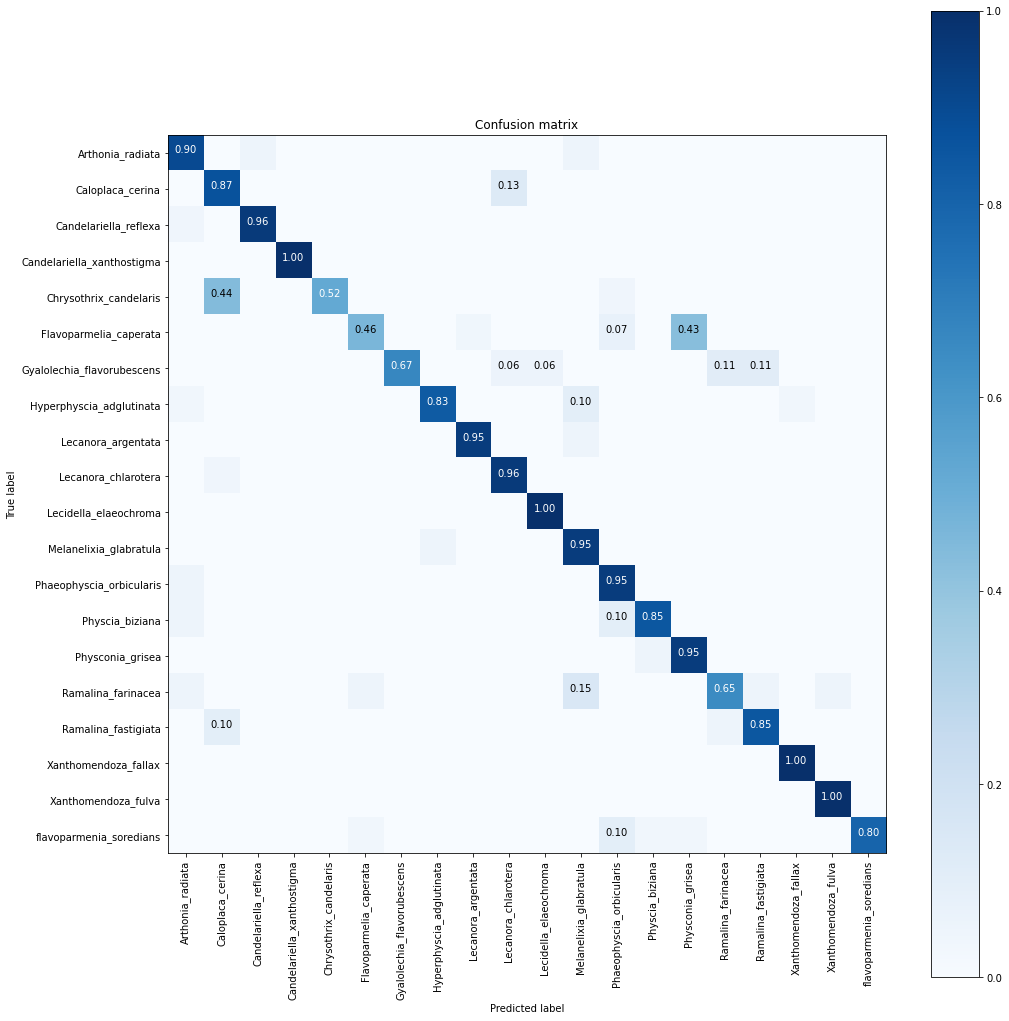

In [35]:
from handcrafted_descriptors.grid_classification import utils
pred = svm.predict(test_feat)
df = evaluated_prediction(pred, test_lab, species)
cm = build_confusion_matrix(df, pred, test_lab,species)
utils.plot_confusion_matrix(cm,species,'confusion_matrix_7','results_bgp/confusion_matrix/',normalize=True,title='Confusion matrix')

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
calculate_and_plot_precision_recall(test_lab, pred, species, 'results_bgp/', 'pr_15')